# 3244-0029
## Report
Check out !! for notes for team. Remove !! before any submission.

In [112]:
import pandas as pd  
import numpy as np
import seaborn as sns
from plotnine import *
import matplotlib.pyplot as plt
import dateutil.parser
import re
from wordcloud import WordCloud 
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords # remove stopwords (and punctuations) such as the, a etc. (as they do not provide any info as to whether or not the news is positive or negative)
from nltk.stem.porter import PorterStemmer # change all the words to stem words (eg loved or loves to love)
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, roc_curve, accuracy_score, classification_report, confusion_matrix

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Aisyah\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [113]:
# data
fake = pd.read_csv("Fake.csv")
true = pd.read_csv("True.csv")

In [114]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [115]:
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


# Pre-Processing

In [116]:
fake['label'] = 0
true['label'] = 1

# concat both datasets into 1, with fake being labelled 0 and true being labelled 1
news = pd.concat([fake, true]).reset_index().drop('index', axis=1)
news.head()

# 44898 rows

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


### Drop rows with empty titles and texts
<br> !! Note for us: none of the titles are empty, only texts, so still remove? 627 rows.
<br> !! because having no text can be a significant attribute of fake news (happen to be majority, 626 out of 627, of the rows with no text are fake news)

In [117]:
len(news[news.title == ' '])

0

In [118]:
news[news.text == ' '].groupby('label').label.count()

label
0    626
1      1
Name: label, dtype: int64

In [119]:
news = news[news.text != ' ']

# 627 rows removed

!! If we end up not removing, remove above cell and include this statement
<br> We found that a vast majority of those with empty 'text' are fake news therefore we shall not remove these rows as this can be a significant indicator or attribute of a fake news.

### Standardising date to '%Y-%m-%d' format

There are multiple date formats like '%d-%b-%y' and '%B %d, %Y' so we should standardise all date entries to a standard format.
<br> But first, we shall remove rows in the dataset which do not actually contain dates since the number of these rows is negligible. 

In [120]:
len('September 29, 2017 ')

19

In [121]:
# entries that are notably long and do not contain actual dates
news[news.apply(lambda row: len(row.date) > 19, axis=1)].date

9358     https://100percentfedup.com/served-roy-moore-v...
15507    https://100percentfedup.com/video-hillary-aske...
15508    https://100percentfedup.com/12-yr-old-black-co...
15839    https://fedup.wpengine.com/wp-content/uploads/...
15840    https://fedup.wpengine.com/wp-content/uploads/...
17432    https://fedup.wpengine.com/wp-content/uploads/...
17433    https://fedup.wpengine.com/wp-content/uploads/...
18933    MSNBC HOST Rudely Assumes Steel Worker Would N...
21869    https://fedup.wpengine.com/wp-content/uploads/...
21870    https://fedup.wpengine.com/wp-content/uploads/...
Name: date, dtype: object

In [122]:
news = news[news.apply(lambda row: len(row.date) < 20, axis=1)]

# 10 rows removed

In [123]:
# converting multiple date formats into a standard format
news['date'] = news.apply(lambda row: dateutil.parser.parse(row['date']).strftime("%Y-%m-%d"), axis=1)
news['date'] = pd.to_datetime(news.date, format='%Y-%m-%d')

In [124]:
news.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44261 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   title    44261 non-null  object        
 1   text     44261 non-null  object        
 2   subject  44261 non-null  object        
 3   date     44261 non-null  datetime64[ns]
 4   label    44261 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 2.0+ MB


### Types of subjects

In [125]:
news.groupby(['label', 'subject']).subject.count()

label  subject        
0      Government News     1497
       Middle-east          778
       News                9050
       US_News              783
       left-news           4307
       politics            6430
1      politicsNews       11271
       worldnews          10145
Name: subject, dtype: int64

### Proportion of fake and true news

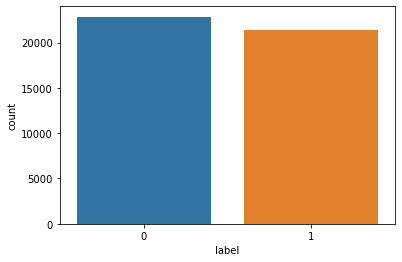

In [126]:
sns.countplot(x='label', data=news)

In [127]:
news.groupby('label').label.count()

# true news starts from index 22845

label
0    22845
1    21416
Name: label, dtype: int64

### Extracting the source of news from 'text' and removing the source stated from 'text'
We noticed that for the true news dataset, majority of the texts starts with 'WASHINGTON (Reuters)', 'SEATTLE/WASHINGTON (Reuters)', etc. which are the sources for the respective news. This adds credibility to the piece of news and may be a significant attribute of a true news. 

We shall create a 'source' column for the source mentioned for each true news, with 'NaN' entered for those without sources stated including the fake news. Then, for each news with a source stated, we shall remove the source from their text.

In [128]:
def extractsource(row):
    if (row.label == 0) | (not bool(re.search(' - ', row.text))):
        return np.nan
    else:
        return row['text'].split(' - ', 1)[0]
    
news['source'] = news.apply(extractsource, axis=1)    

In [129]:
def textonly(row):
    if (row.label == 0) | (not bool(re.search(' - ', row.text))):
        return row.text
    else:
        return row['text'].split(' - ', 1)[1]
    
news['text'] = news.apply(textonly, axis=1)

In [130]:
news.iloc[31092] 

# Check: label is 1 (true news) but it's without source, so source is nan

title        Obama drinks coconut water to cool down in Laos
text       U.S. President Barack Obama visited a street m...
subject                                         politicsNews
date                                     2016-09-07 00:00:00
label                                                      1
source                                                   NaN
Name: 31728, dtype: object

In [131]:
news.head()

,title,text,subject,date,label,source
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,2017-12-31,0,NaN
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,2017-12-31,0,NaN
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,2017-12-30,0,NaN
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,2017-12-29,0,NaN
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,2017-12-25,0,NaN


### Further cleaning for wordclouds

In [132]:
true_cleaned = news[news["label"]==1]
fake_cleaned = news[news["label"]==0]

In [133]:
news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44261 entries, 0 to 44897
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   title    44261 non-null  object        
 1   text     44261 non-null  object        
 2   subject  44261 non-null  object        
 3   date     44261 non-null  datetime64[ns]
 4   label    44261 non-null  int64         
 5   source   21388 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 3.6+ MB


In [134]:
true_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21416 entries, 23481 to 44897
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   title    21416 non-null  object        
 1   text     21416 non-null  object        
 2   subject  21416 non-null  object        
 3   date     21416 non-null  datetime64[ns]
 4   label    21416 non-null  int64         
 5   source   21388 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 1.1+ MB


In [135]:
fake_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22845 entries, 0 to 23480
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   title    22845 non-null  object        
 1   text     22845 non-null  object        
 2   subject  22845 non-null  object        
 3   date     22845 non-null  datetime64[ns]
 4   label    22845 non-null  int64         
 5   source   0 non-null      object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 1.2+ MB


In [136]:
re.sub('[^a-zA-Z]', ' ', 'money$𝛿 $100,000') #𝛿

'money           '

In [137]:
re.sub('\W+', ' ', 'money$𝛿100,000â€ ™') #𝛿, â not removed

'money 𝛿100 000â '

# TITLE & TEXT CLEANING AND WORLDCLOUD
To output wordclouds for frequently used words in the titles and texts respectively, we shall first 'clean' the titles and texts by replacing non-alphanumeric characters, which includes $, €, ™, etc.,  with spaces, standardising all letters to lower case and appending the cleaned titles and texts into a list, ready for wordcloud generation.
<br> !! Note for team: can't remove special symbols like 𝛿, â, etc. unless we identify all of them individually

## FAKE NEWS

In [138]:
# \W matching non-alphanumeric character ie. [^a-zA-Z0-9_]

def cleanwords(row, col, cleanedlist):
    new = re.sub('\W+', ' ', row[col]) # replace punctuations/ non-alphanumeric characters by spaces so words aren't stuck together
    new = new.lower() # change all capital letters to lower case
    new = new.split() # split strings into a list of words
    new = ' '.join(new)
    cleanedlist.append(new)

In [139]:
fake_title_cleaned = [] # add cleaned titles here
fake_text_cleaned = [] # add cleaned texts here

In [140]:
fake_cleaned.apply(lambda row: cleanwords(row, 'title', fake_title_cleaned), axis=1);

In [141]:
fake_cleaned.apply(lambda row: cleanwords(row, 'text', fake_text_cleaned), axis=1);

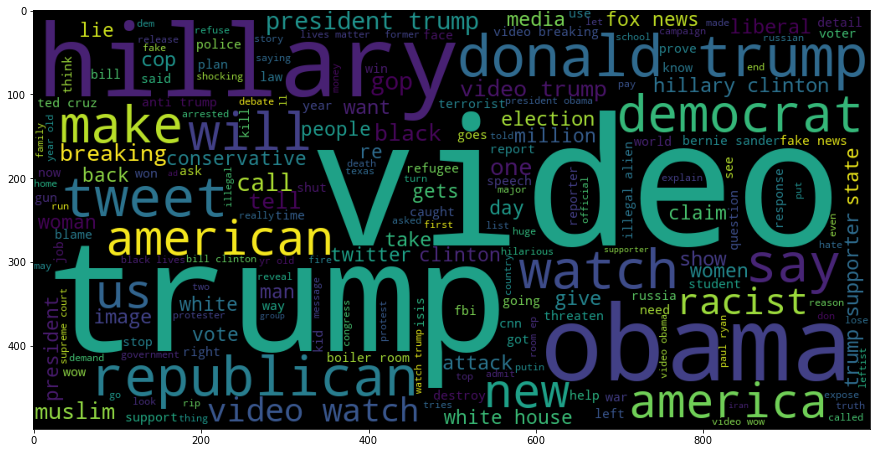

In [142]:
fake_titles = (" ").join(fake_title_cleaned)
fake_titles_wordcloud = WordCloud(width = 1000, height = 500).generate(fake_titles)
plt.figure(figsize=(15,8))
plt.imshow(fake_titles_wordcloud)

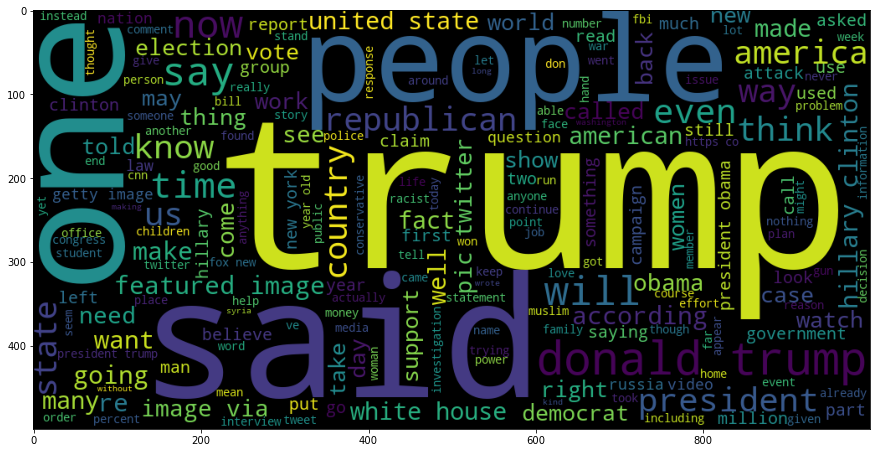

In [143]:
fake_texts = (" ").join(fake_text_cleaned)
fake_texts_wordcloud = WordCloud(width = 1000, height = 500).generate(fake_texts)
plt.figure(figsize=(15,8))
plt.imshow(fake_texts_wordcloud)

## TRUE NEWS

In [144]:
true_title_cleaned = [] # add cleaned titles here
true_text_cleaned = [] # add cleaned texts here

In [145]:
true_cleaned.apply(lambda row: cleanwords(row, 'title', true_title_cleaned), axis=1);

In [146]:
true_cleaned.apply(lambda row: cleanwords(row, 'text', true_text_cleaned), axis=1);

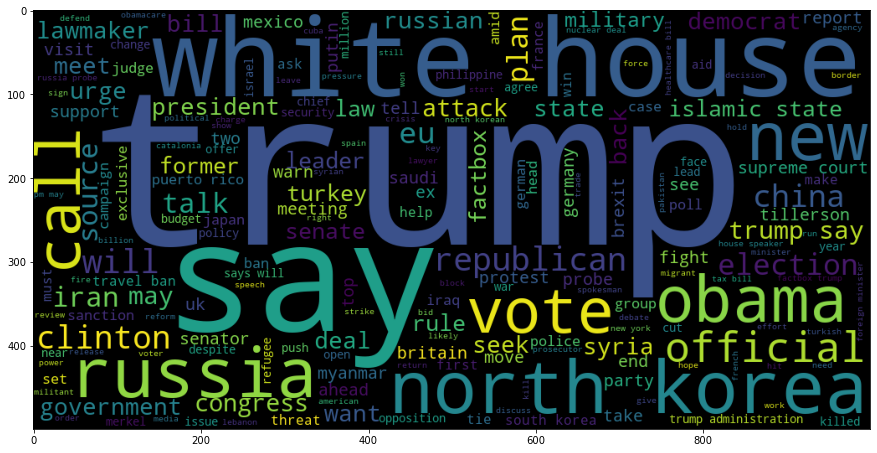

In [147]:
true_titles = (" ").join(true_title_cleaned)
true_titles_wordcloud = WordCloud(width = 1000, height = 500).generate(true_titles)
plt.figure(figsize=(15,8))
plt.imshow(true_titles_wordcloud)

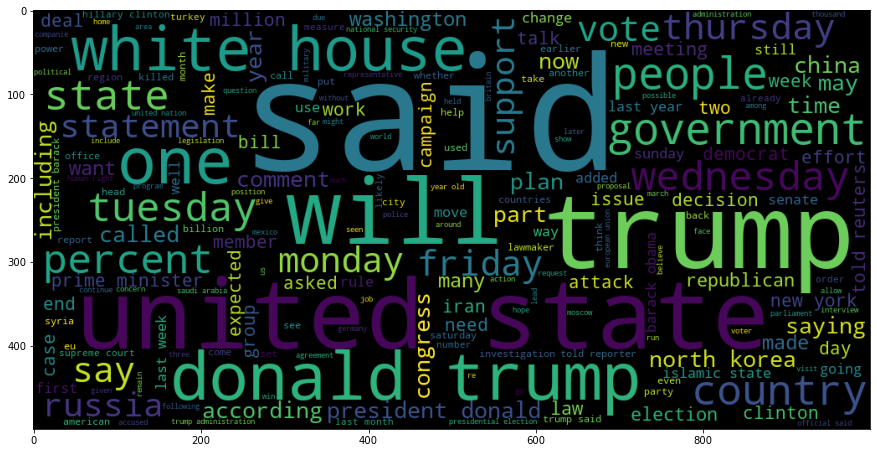

In [148]:
true_texts = (" ").join(true_text_cleaned)
true_texts_wordcloud = WordCloud(width = 1000, height = 500).generate(true_texts)
plt.figure(figsize=(15,8))
plt.imshow(true_texts_wordcloud)

## COMBINED NEWS

In [149]:
news_title_cleaned  = [] # add cleaned titles here
news_text_cleaned = [] # add cleaned texts here

In [150]:
news.apply(lambda row: cleanwords(row, 'title', news_title_cleaned), axis=1);

In [151]:
news.apply(lambda row: cleanwords(row, 'text', news_text_cleaned), axis=1);

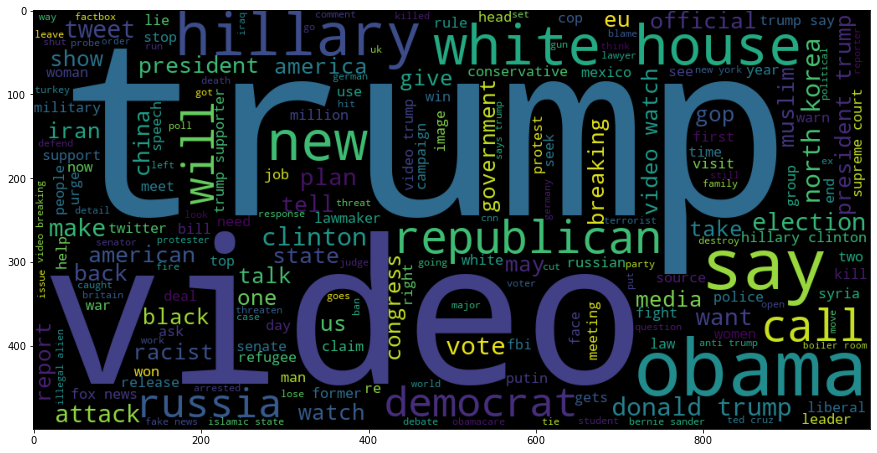

In [152]:
news_titles = (" ").join(news_title_cleaned)
news_titles_wordcloud = WordCloud(width = 1000, height = 500).generate(news_titles)
plt.figure(figsize=(15,8))
plt.imshow(news_titles_wordcloud)

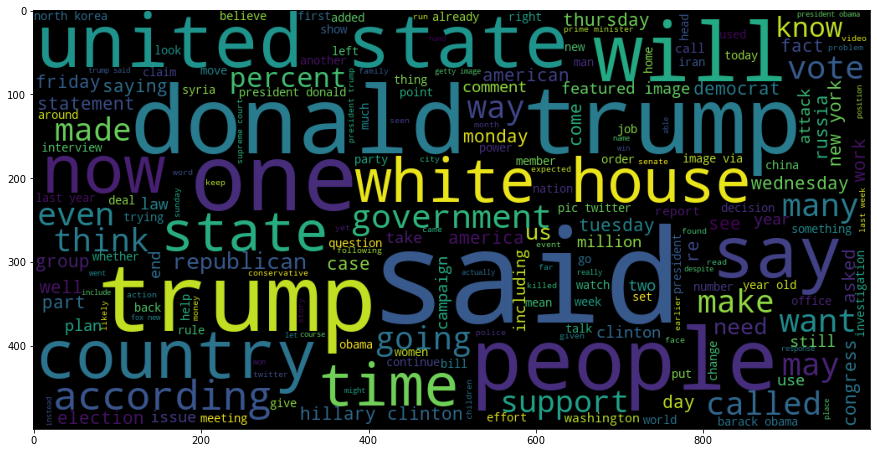

In [153]:
news_texts = (" ").join(news_text_cleaned)
news_texts_wordcloud = WordCloud(width = 1000, height = 500).generate(news_texts)
plt.figure(figsize=(15,8))
plt.imshow(news_texts_wordcloud)

In [154]:
def cleanwordsfordata(row, col):
    new = re.sub('\W+', ' ', row[col]) # replace punctuations/ non-alphanumeric characters by spaces so words aren't stuck together
    new = new.lower() # change all capital letters to lower case
    new = new.split() # split strings into a list of words
    new = ' '.join(new)
    return new

news_cloud_ed = news.copy()

In [155]:
news_cloud_ed['title'] = news.apply(lambda row: cleanwordsfordata(row, 'title'), axis=1)

In [156]:
news_cloud_ed['text'] = news.apply(lambda row: cleanwordsfordata(row, 'text'), axis=1)

In [158]:
news_cloud_ed.head()

,title,text,subject,date,label,source
0,donald trump sends out embarrassing new year s...,donald trump just couldn t wish all americans ...,News,2017-12-31,0,NaN
1,drunk bragging trump staffer started russian c...,house intelligence committee chairman devin nu...,News,2017-12-31,0,NaN
2,sheriff david clarke becomes an internet joke ...,on friday it was revealed that former milwauke...,News,2017-12-30,0,NaN
3,trump is so obsessed he even has obama s name ...,on christmas day donald trump announced that h...,News,2017-12-29,0,NaN
4,pope francis just called out donald trump duri...,pope francis used his annual christmas day mes...,News,2017-12-25,0,NaN


In [157]:
news.head()

,title,text,subject,date,label,source
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,2017-12-31,0,NaN
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,2017-12-31,0,NaN
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,2017-12-30,0,NaN
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,2017-12-29,0,NaN
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,2017-12-25,0,NaN


In [160]:
# news.to_csv(r'C:\Users\Aisyah\Desktop\CS3244\project\news.csv', index = False, header=True)

In [161]:
# news_cloud_ed.to_csv(r'C:\Users\Aisyah\Desktop\CS3244\project\news_cloud_ed.csv', index = False, header=True)